In [1]:
%load_ext autoreload

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

True

In [173]:
%autoreload 2

import datetime
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler

from estuary.constants import EIGHT_TO_4
from estuary.util import contrast_stretch, false_color

In [3]:
def parse_dt_from_asset_id(asset_id: str) -> datetime.datetime:
    """Parse acquisition datetime from file stem prefix YYYYMMDD_HHMMSS_*"""
    datetime_str = "_".join(asset_id.split("_")[:2])
    date_format = "%Y%m%d_%H%M%S"
    return datetime.datetime.strptime(datetime_str, date_format)

In [4]:
skipped_grids = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].tolist()
print(skipped_grids)

[13, 24, 30, 36, 42, 47, 49, 60, 61, 69, 71, 74, 75, 76, 78, 80, 82, 89, 90, 91, 231]


In [7]:
def viz_from_iter(iii):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

    for ax in axes.flatten():
        ax.axis("off")
        try:
            row = next(iii)
            pth = Path(row.source_tif)
            with rasterio.open(pth) as src:
                data = src.read()
                nodata = src.read(1, masked=True).mask
                img = false_color(data, nodata)
            ax.imshow(img)
        except:
            continue
    fig.tight_layout()
    plt.show()

In [26]:
def asset_id_from_pth(pth):
    return "_".join(Path(pth).stem.split("_")[:2])


labels = pd.read_csv("/Volumes/x10pro/estuary/dove/labels.csv")
labels["asset_id"] = labels.source_tif.apply(asset_id_from_pth)
labels = labels[(~labels.region.isin(skipped_grids))].copy()
labels.head(2)

,region,source_tif,label,acquired,instrument,asset_id
0,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-09-03 18:37:27,superdove,20220903_183727
1,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-11-02 18:35:56,superdove,20221102_183556


In [27]:
cluster_labels = pd.read_csv("/Volumes/x10pro/estuary/low_quality/quality_labels.csv")
cluster_labels["asset_id"] = cluster_labels.source_tif.apply(asset_id_from_pth)
cluster_labels = cluster_labels[(~cluster_labels.region.isin(skipped_grids))].copy()

cluster_labels.head(2)

,Unnamed: 0,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,...,visible_percent,asset_id,year,dove,month,region,base,source_tif,source_udm,cluster_label
0,0,2017-05-28T17:43:42.631067Z,0.01,86,100,0.00,0,True,4.0,0,...,100,20170528_174342,2017,dove,5,16,ca_all,/Volumes/x10pro/estuary/ca_all/dove/results/20...,/Volumes/x10pro/estuary/ca_all/dove/results/20...,-1
1,1,2017-05-27T17:44:13.202718Z,0.05,64,33,0.56,56,True,4.0,0,...,44,20170527_174413,2017,dove,5,16,ca_all,/Volumes/x10pro/estuary/ca_all/dove/results/20...,/Volumes/x10pro/estuary/ca_all/dove/results/20...,-1


In [28]:
merged = pd.merge(left=labels, right=cluster_labels, on=["asset_id", "region"])
merged.head(2)

,region,source_tif_x,label,acquired_x,instrument_x,asset_id,Unnamed: 0,acquired_y,anomalous_pixels,clear_confidence_percent,...,view_angle,visible_confidence_percent,visible_percent,year,dove,month,base,source_tif_y,source_udm,cluster_label
0,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-09-03 18:37:27,superdove,20220903_183727,17598,2022-09-03T18:37:27.567423Z,0.0,96,...,5.0,82,100,2022,superdove,9,ca_all,/Volumes/x10pro/estuary/ca_all/superdove/resul...,/Volumes/x10pro/estuary/ca_all/superdove/resul...,0
1,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-11-02 18:35:56,superdove,20221102_183556,17619,2022-11-02T18:35:56.950486Z,0.0,90,...,1.9,73,80,2022,superdove,11,ca_all,/Volumes/x10pro/estuary/ca_all/superdove/resul...,/Volumes/x10pro/estuary/ca_all/superdove/resul...,0


In [176]:
stats

{'means': [0.5283515857719048,
  0.5815469461739448,
  0.6507556649111267,
  0.6716909211853819,
  0.6097262389628422,
  0.6195141539980848,
  0.5390416449583938,
  0.5710700978634757],
 'stds': [0.14172474432994048,
  0.14480069820928748,
  0.11428588543841196,
  0.10409361867480499,
  0.1354707897079432,
  0.12103983693211352,
  0.15604386739037146,
  0.1667802110133206],
 'lambdas': [0.18345703273631828,
  0.1929331914461388,
  0.09808919507868571,
  0.08475936383820722,
  0.14610589224560147,
  0.12688489511522835,
  0.2362783162480549,
  0.1904602738568595],
 'power_scale': True,
 'max_raw_pixel_value': 7000,
 'max_std': 3.0}

In [198]:
with open("/Users/kyledorman/data/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

pt = PowerTransformer(standardize=False)
pt.lambdas_ = np.array(stats["lambdas"])
max_value = pt.transform(np.array([stats["max_raw_pixel_value"]] * 8)[None])[0]
st0 = StandardScaler(with_mean=False)
st0.scale_ = max_value
st = StandardScaler()
st.scale_ = np.array(stats["stds"])
st.mean_ = np.array(stats["means"])

norm = Pipeline([("PowerTransformer", pt), ("StandardScaler0", st0)])

In [201]:
shp = img_data0.shape
norm.transform(img_data0.reshape(len(img_data0), -1).T).T.reshape(shp).max(axis=(1, 2))

array([0.18803139, 0.18554401, 0.2187959 , 0.22460333, 0.20256849,
       0.20771134, 0.17367958, 0.18452628], dtype=float32)

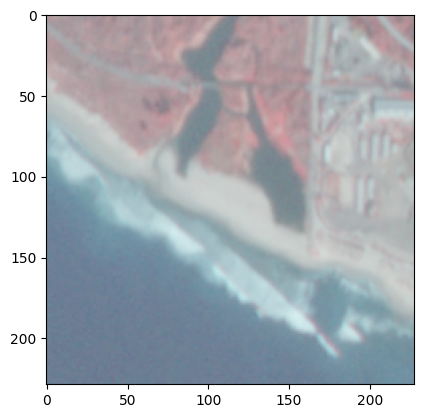

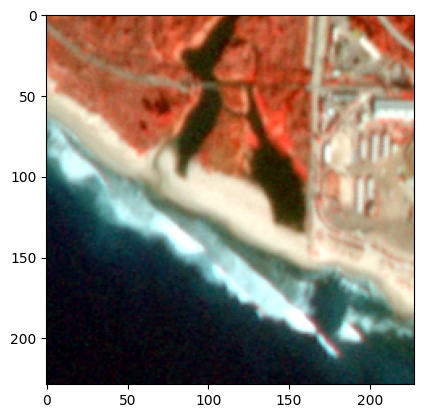

In [270]:
row = merged[merged.label == "open"].iloc[1000]
pth = row.source_tif_x
with rasterio.open(pth) as src:
    data0 = src.read(out_dtype=np.float32)
    nodata0 = src.read(1, masked=True).mask

if len(data0) == 4:
    img_data0 = np.zeros((8, *data0.shape[1:]), dtype=data0.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img_data0[b] = data0[i]
else:
    img_data0 = data0

shp = img_data0.shape
img_data0 = norm.transform(img_data0.reshape(len(img_data0), -1).T).T.reshape(shp)

plt.figure()
plt.imshow(img_data0[[7, 5, 3]].transpose((1, 2, 0)).clip(0, 1))

plt.figure()
plt.imshow(contrast_stretch(img_data0[[7, 5, 3]]).transpose((1, 2, 0)))

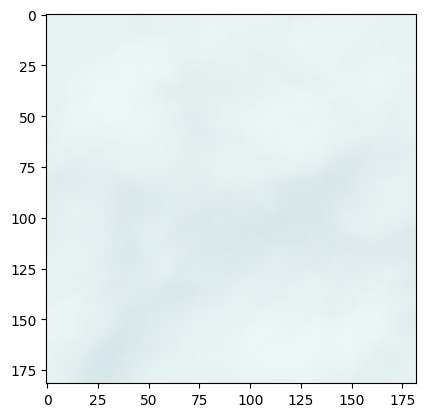

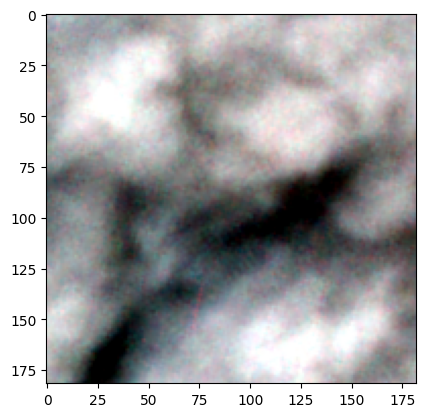

In [437]:
pth = (
    merged[
        (merged.cluster_label == 1)
        # & (merged.region == row.region)
    ]
    .iloc[5]
    .source_tif_x
)
with rasterio.open(pth) as src:
    data1 = src.read(out_dtype=np.float32)
    nodata1 = src.read(1, masked=True).mask

if len(data1) == 4:
    img_data1 = np.zeros((8, *data1.shape[1:]), dtype=data.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img_data1[b] = data1[i]
else:
    img_data1 = data1

shp = img_data1.shape
img_data1 = norm.transform(img_data1.reshape(len(img_data1), -1).T).T.reshape(shp)

plt.figure()
plt.imshow(img_data1[[7, 5, 3]].transpose((1, 2, 0)).clip(0, 1))

plt.figure()
plt.imshow(contrast_stretch(img_data1[[7, 5, 3]]).transpose((1, 2, 0)))

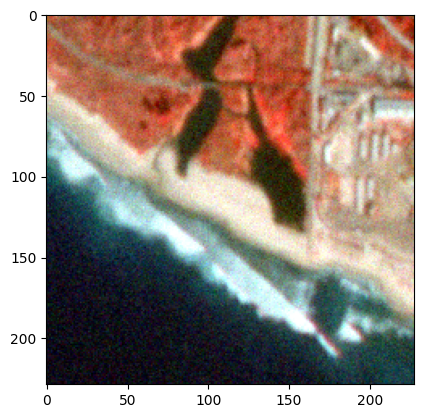

In [438]:
def add_iso_noise(image, iso_gain=1.0, read_noise_std_dev=0.01, saturation_level=1.0):
    """
    Add realistic ISO-like noise (photon shot noise + read noise).

    Args:
        image (np.ndarray): Float image in [0, 1].
        iso_gain (float): Simulated ISO gain (>1 increases noise).
        read_noise_std_dev (float): Std dev of read noise (in [0,1] range).
        saturation_level (float): Max signal value before clipping.

    Returns:
        np.ndarray: Noisy image in [0,1].
    """
    # image = np.clip(image, 0, 1).astype(np.float32)

    scale = 8000

    # 1. Convert to "photon counts" (arbitrary units).
    # Scale so mean photon counts roughly match brightness * saturation.
    photon_counts = image * saturation_level * scale  # arbitrary scale

    # 2. Add photon shot noise (Poisson)
    noisy_counts = np.random.poisson(photon_counts).astype(np.float32)

    # 3. Convert back to normalized [0,1] intensity
    shot_noisy_image = noisy_counts / (saturation_level * scale)

    # 4. Add read noise (Gaussian)
    read_noise = np.random.normal(0, read_noise_std_dev, image.shape).astype(np.float32)
    shot_noisy_image += read_noise

    # 5. Apply digital gain (ISO)
    noisy_image = shot_noisy_image * iso_gain

    # 6. Clip to [0,1]
    return np.clip(noisy_image, 0.0, 1.0)


img_data3 = add_iso_noise(0.1 + img_data0[[7, 5, 3]].transpose((1, 2, 0)), read_noise_std_dev=0.015)
plt.figure()
plt.imshow(contrast_stretch(img_data3.transpose((2, 0, 1))).transpose((1, 2, 0)))

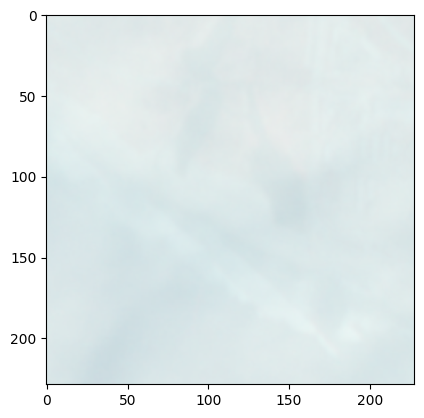

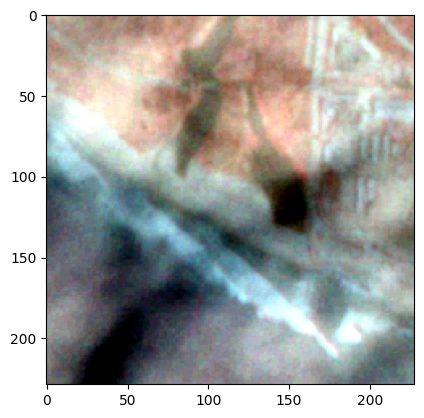

In [440]:
from PIL import Image

a = (255 * img_data1[[7, 5, 3]].clip(0, 1).transpose((1, 2, 0))).astype(np.uint8)
img = Image.fromarray(a).resize((img_data0.shape[2], img_data0.shape[1]))
image_data11 = np.array(img).transpose((2, 0, 1)).astype(np.float32) / 255.0

img_data2 = np.average(
    np.concatenate([image_data11[None], img_data0[[7, 5, 3]][None]]), weights=[0.9, 0.1], axis=0
)
plt.figure()
plt.imshow(img_data2.transpose((1, 2, 0)).clip(0, 1))

plt.figure()
plt.imshow(contrast_stretch(img_data2).transpose((1, 2, 0)))

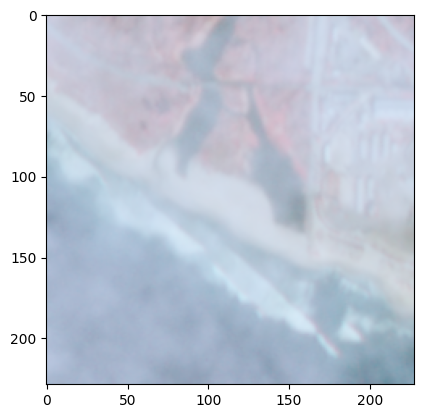

In [462]:
import scipy.ndimage as ndi


def fbm_noise(shape, octaves=5, lacunarity=2.0, gain=0.5, sigma0=40.0, seed=None):
    """
    Fast approximate fBM via gaussian blurs at multiple scales.
    Produces smooth cloud-like fields in [0,1].
    """
    rng = np.random.default_rng(seed)
    base = rng.normal(0, 1, shape).astype(np.float32)
    h, w = shape
    acc = np.zeros_like(base)
    amp = 1.0
    sigma = sigma0
    for _ in range(octaves):
        acc += amp * ndi.gaussian_filter(base, sigma=sigma, mode="reflect")
        amp *= gain
        sigma /= lacunarity
    acc -= acc.min()
    acc /= acc.max() + 1e-8
    return acc


def percentile_threshold(field, coverage):
    """Pick threshold to achieve ~coverage fraction above threshold."""
    return np.percentile(field, 100 * (1 - coverage))


# ---------- Haze ----------
def simulate_haze(image01, beta=1.2, A=(0.85, 0.9, 1.0), strength=1.0, seed=None):
    """
    Koschmieder-like: I = J * t + A * (1 - t), with spatial t from smooth noise.
    - beta: scattering strength (higher -> more haze)
    - A: airlight color (tuple per channel; blue-ish lifts sky/haze)
    - strength: overall mix multiplier [0..1]
    """
    img = image01.astype(np.float32)
    H, W = img.shape[:2]
    ch = 1 if img.ndim == 2 else img.shape[2]

    # Smooth pseudo-depth field in [0,1]
    depth = fbm_noise((H, W), octaves=5, sigma0=H / 5, seed=seed)
    # Transmittance
    t = np.exp(-beta * depth).astype(np.float32)  # in (0,1]

    # Expand to channels
    tC = t[..., None] if ch > 1 else t
    A = np.asarray(A, np.float32)
    if ch == 1:
        A = np.asarray([A[0] if A.ndim else A], np.float32)
        A = A[0]
    else:
        if A.size == 1:
            A = np.full((ch,), float(A), np.float32)
        elif A.size != ch:
            A = np.resize(A, (ch,)).astype(np.float32)

    # Apply haze
    if ch == 1:
        hazy = img * t + A * (1 - t)
    else:
        hazy = img * tC + A * (1 - tC)

    # Global strength blend (0=no haze, 1=full haze)
    out = (1 - strength) * img + strength * hazy
    return np.clip(out, 0, 1)


a = simulate_haze(img_data0[[7, 5, 3]].transpose((1, 2, 0)), seed=2)
plt.imshow(a)

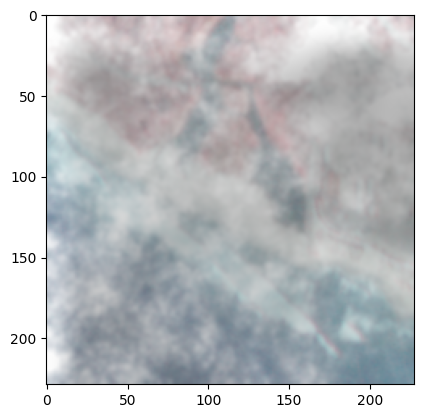

In [498]:
# ---------- Clouds + shadows ----------
def simulate_clouds(
    image01,
    coverage=0.25,  # fraction of image cloudy
    softness=0.6,  # 0 hard edges, 1 very soft
    cloud_brightness=1.0,  # albedo of cloud layer
    cloud_tint=(1.0, 1.0, 1.0),
    halo_blur=3.0,  # small glow around cloud tops
    shadow_strength=0.35,  # 0..1 how dark shadows are
    shadow_blur=7.0,  # softness of shadow
    sun_shift=(20, 15),  # (dy, dx) pixel shift for shadow projection
    seed=None,
):
    """
    Composites textured clouds and their shadows over the image.
    """
    img = image01.astype(np.float32)
    H, W = img.shape[:2]
    ch = 1 if img.ndim == 2 else img.shape[2]

    # Cloud field
    field = fbm_noise((H, W), octaves=6, sigma0=H / 5, seed=seed)
    thr = percentile_threshold(field, coverage)
    # Soft mask around threshold
    k = max(1e-3, softness * 12.0)
    alpha = 1 / (1 + np.exp(-(field - thr) * k))  # smoothstep via sigmoid
    # Optional halo/glow
    if halo_blur > 0:
        alpha = np.clip(alpha + 0.25 * ndi.gaussian_filter(alpha, halo_blur), 0, 1)

    # Cloud color
    tint = np.asarray(cloud_tint, np.float32)
    if ch == 1:
        cloud = np.full(
            (H, W), cloud_brightness * float(tint[0] if tint.size > 0 else 1.0), np.float32
        )
    else:
        if tint.size == 1:
            tint = np.full((ch,), float(tint), np.float32)
        elif tint.size != ch:
            tint = np.resize(tint, (ch,)).astype(np.float32)
        cloud = np.clip(tint * cloud_brightness, 0, 1)[None, None, :].repeat(H, 0).repeat(W, 1)

    # Composite clouds
    aC = alpha[..., None] if ch > 1 else alpha
    with_clouds = (1 - aC) * img + aC * cloud

    # Shadows: shift cloud mask along sun, blur, darken underlying image
    dy, dx = sun_shift
    shadow = np.zeros_like(alpha)
    y0, y1 = max(0, dy), min(H, H + dy)
    x0, x1 = max(0, dx), min(W, W + dx)
    yy0, yy1 = max(0, -dy), min(H, H - dy)
    xx0, xx1 = max(0, -dx), min(W, W - dx)
    shadow[y0:y1, x0:x1] = alpha[yy0:yy1, xx0:xx1]
    if shadow_blur > 0:
        shadow = ndi.gaussian_filter(shadow, shadow_blur)

    sC = shadow[..., None] if ch > 1 else shadow
    darkener = 1.0 - shadow_strength * sC
    with_shadows = np.clip(with_clouds * darkener, 0, 1)

    return with_shadows, alpha  # return mask too if you want to visualize


a, _ = simulate_clouds(
    img_data0[[7, 5, 3]].transpose((1, 2, 0)), seed=2, coverage=0.3, softness=0.5
)
# a, _ = simulate_clouds(0.4 * np.ones((256, 256, 3), dtype=np.float32), seed=2)
plt.imshow(a)

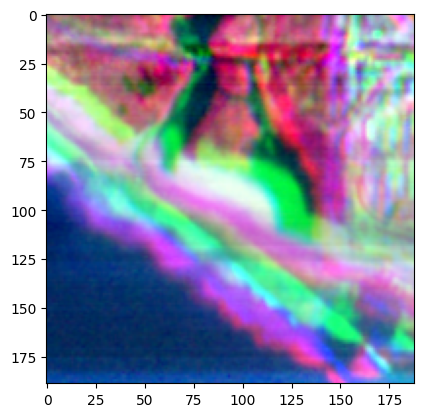

In [478]:
import cv2
import numpy as np


def _compose_affine(A, B):
    """Compose two 2x3 affines: result = A ∘ B (apply B first, then A)."""
    A3 = np.vstack([A, [0, 0, 1]])
    B3 = np.vstack([B, [0, 0, 1]])
    return (A3 @ B3)[:2]


def _rot_affine(cx, cy, deg):
    """2x3 rotation about center (cx, cy)."""
    return cv2.getRotationMatrix2D((cx, cy), deg, 1.0).astype(np.float32)


def _shear_x_affine(k):
    """2x3 shear along x: x' = x + k*y."""
    return np.array([[1, k, 0], [0, 1, 0]], dtype=np.float32)


def _translate_affine(dx, dy):
    return np.array([[1, 0, dx], [0, 1, dy]], dtype=np.float32)


def misregister_angled(image, params_per_band, fill_value=0.0, interp=cv2.INTER_LINEAR):
    """
    Apply angled, linear drift (shear) per band.
    image: (H,W,C) or (H,W) array (any dtype). No wrap; pads with fill_value.
    params_per_band: list of dicts, one per band:
      {
        'angle_deg': 30.0,          # direction along which band slides
        'edge_shift_px': 15.0,      # total shift accumulated across the image
        'offset_dx': 0.0,           # optional constant translation
        'offset_dy': 0.0            # optional constant translation
      }
    Note: edge_shift_px is the net displacement from top to bottom *perpendicular*
          to the sliding direction. Positive values move along +angle direction.
    """
    img = np.asarray(image)
    squeeze = False
    if img.ndim == 2:
        img = img[..., None]
        squeeze = True

    H, W, C = img.shape
    cx, cy = (W - 1) / 2.0, (H - 1) / 2.0
    out = np.empty_like(img)

    for c in range(C):
        p = {"angle_deg": 0.0, "edge_shift_px": 0.0, "offset_dx": 0.0, "offset_dy": 0.0}
        p.update(params_per_band[min(c, len(params_per_band) - 1)])

        theta = float(p["angle_deg"])
        edge_shift = float(p["edge_shift_px"])
        dx0 = float(p.get("offset_dx", 0.0))
        dy0 = float(p.get("offset_dy", 0.0))

        # Length across which the shear accumulates = image extent perpendicular to theta.
        # A simple choice is the image height if theta≈0°, width if theta≈90°.
        # A more accurate effective length projects the image size onto the perpendicular axis:
        # L_eff ≈ |H*cos(theta)| + |W*sin(theta)|
        rad = np.deg2rad(theta)
        L_eff = abs(H * np.cos(rad)) + abs(W * np.sin(rad))
        if L_eff < 1e-6:
            L_eff = max(H, W)

        k = edge_shift / L_eff  # shear factor

        # Build M = T(dx0,dy0) ∘ R(+theta) ∘ Sx(k) ∘ R(-theta)
        Rm = _rot_affine(cx, cy, -theta)
        Sx = _shear_x_affine(k)
        Rp = _rot_affine(cx, cy, +theta)
        T0 = _translate_affine(dx0, dy0)

        M = _compose_affine(T0, _compose_affine(Rp, _compose_affine(Sx, Rm)))

        out[..., c] = cv2.warpAffine(
            img[..., c],
            M,
            (W, H),
            flags=interp,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=fill_value,
        )

    return out[..., 0] if squeeze else out


plt.figure()
params = [
    {"angle_deg": 30, "edge_shift_px": -10},  # R reference
    {"angle_deg": 30, "edge_shift_px": +15, "offset_dx": 6, "offset_dy": -4},  # G slides +15px
    {"angle_deg": 0, "edge_shift_px": 0},  # B slides -10px (opposite)
]
img01 = img_data0[[7, 5, 3]].transpose((1, 2, 0))
mis = misregister_angled(img01, params, fill_value=0.0)[20:-20, 20:-20]
plt.imshow(contrast_stretch(mis))

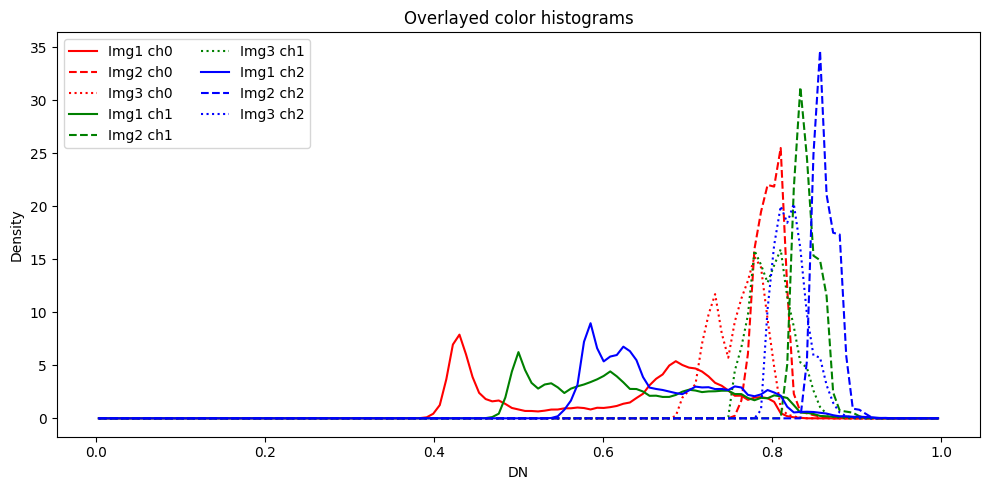

In [428]:
import cv2
import matplotlib.pyplot as plt

img1 = img_data0[[7, 5, 3]].transpose((1, 2, 0))
img2 = img_data1[[7, 5, 3]].transpose((1, 2, 0))
img3 = img_data2.transpose((1, 2, 0))

MAX_DN = 1
MIN_DN = 0
BINS = 129

colors = ("r", "g", "b")

plt.figure(figsize=(10, 5))

for c, col in enumerate(colors):
    v1 = img1[..., c].ravel()
    v2 = img2[..., c].ravel()
    v3 = img3[..., c].ravel()

    # normalized histograms (so image size doesn't matter)
    h1, edges = np.histogram(v1, bins=BINS, range=(MIN_DN, MAX_DN), density=True)
    h2, _ = np.histogram(v2, bins=BINS, range=(MIN_DN, MAX_DN), density=True)
    h3, _ = np.histogram(v3, bins=BINS, range=(MIN_DN, MAX_DN), density=True)
    x = 0.5 * (edges[1:] + edges[:-1])

    plt.plot(x, h1, linestyle="-", label=f"Img1 ch{c}", color=col)
    plt.plot(x, h2, linestyle="--", label=f"Img2 ch{c}", color=col)
    plt.plot(x, h3, linestyle=":", label=f"Img3 ch{c}", color=col)

plt.title("Overlayed color histograms")
plt.xlabel("DN")
plt.ylabel("Density")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [339]:
a = data1[[3, 2, 1]]
b = data0[[3, 2, 1]]
pt1 = PowerTransformer()
pt2 = PowerTransformer()
e = pt1.fit_transform(a.transpose((1, 2, 0)).reshape((-1, 3))).T.reshape(a.shape)
c = pt2.fit_transform(b.transpose((1, 2, 0)).reshape((-1, 3)))
d = pt1.inverse_transform(c).T.reshape(b.shape)

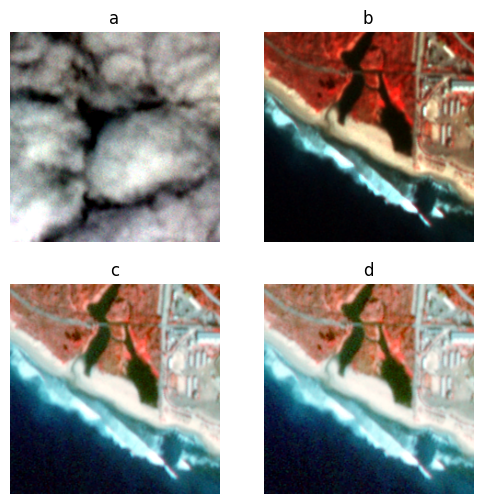

In [340]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
for ax in axes.flatten():
    ax.axis("off")
axes[0, 0].imshow(contrast_stretch(a).transpose((1, 2, 0)))
axes[0, 0].set_title("a")
axes[0, 1].imshow(contrast_stretch(b).transpose((1, 2, 0)))
axes[0, 1].set_title("b")
axes[1, 0].imshow(contrast_stretch(c.T.reshape(b.shape)).transpose((1, 2, 0)))
axes[1, 0].set_title("c")
axes[1, 1].imshow(contrast_stretch(d).transpose((1, 2, 0)))
_ = axes[1, 1].set_title("d")

In [335]:
b.min(axis=(1, 2)).round(), d.min(axis=(1, 2)).round(), a.min(axis=(1, 2)).round()

(array([161., 188., 249.], dtype=float32),
 array([1134., 1224., 1134.], dtype=float32),
 array([1076., 1208., 1152.], dtype=float32))

In [334]:
b.max(axis=(1, 2)).round(), d.max(axis=(1, 2)).round(), a.max(axis=(1, 2)).round()

(array([3340., 4821., 4740.], dtype=float32),
 array([2763., 2700., 2272.], dtype=float32),
 array([3130., 3165., 2656.], dtype=float32))